In [2]:
import os
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

1.12.0


In [3]:
image_size = 160 
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                './train/',  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                './test', # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 550 images belonging to 5 classes.
Found 180 images belonging to 5 classes.


In [5]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

In [6]:
base_model.trainable = False

In [7]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [8]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(5, activation='sigmoid')
])

In [9]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
len(model.trainable_variables)

2

In [12]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/10
17/17 [==============================] - 34s 2s/step - loss: 1.6412 - acc: 0.2066 - val_loss: 1.6724 - val_acc: 0.2812
Epoch 2/10
17/17 [==============================] - 30s 2s/step - loss: 1.5907 - acc: 0.2751 - val_loss: 1.6437 - val_acc: 0.2687
Epoch 3/10
17/17 [==============================] - 30s 2s/step - loss: 1.5553 - acc: 0.2711 - val_loss: 1.6252 - val_acc: 0.2875
Epoch 4/10
17/17 [==============================] - 30s 2s/step - loss: 1.5332 - acc: 0.3061 - val_loss: 1.6003 - val_acc: 0.2500
Epoch 5/10
17/17 [==============================] - 31s 2s/step - loss: 1.4448 - acc: 0.4063 - val_loss: 1.5816 - val_acc: 0.3063
Epoch 6/10
17/17 [==============================] - 32s 2s/step - loss: 1.4401 - acc: 0.3897 - val_loss: 1.5779 - val_acc: 0.3125
Epoch 7/10
17/17 [==============================] - 33s 2s/step - loss: 1.3873 - acc: 0.4318 - val_loss: 1.5546 - val_acc: 0.3375
Epoch 8/10
17/17 [==============================] - 34s 2s/step - loss: 1.3817 - acc: 0.44

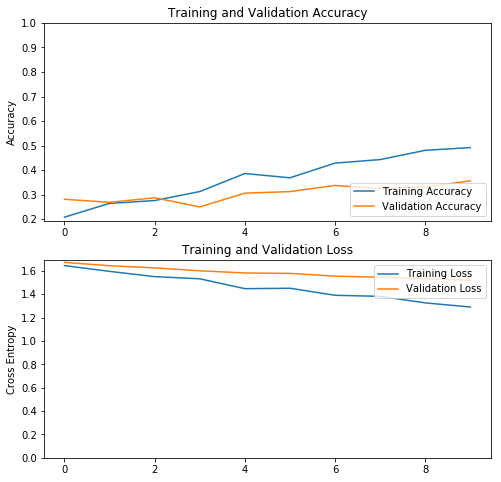

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [14]:
base_model.trainable = True

In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [16]:

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 1,868,997
Non-trainable params: 395,392
_________________________________________________________________


In [18]:
len(model.trainable_variables)

58

In [19]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Epoch 1/10
17/17 [==============================] - 62s 4s/step - loss: 1.1401 - acc: 0.5957 - val_loss: 1.4679 - val_acc: 0.3937
Epoch 2/10
17/17 [==============================] - 62s 4s/step - loss: 0.9073 - acc: 0.7721 - val_loss: 1.4495 - val_acc: 0.4000
Epoch 3/10
17/17 [==============================] - 58s 3s/step - loss: 0.8148 - acc: 0.8022 - val_loss: 1.4268 - val_acc: 0.4375
Epoch 4/10
17/17 [==============================] - 57s 3s/step - loss: 0.6835 - acc: 0.9204 - val_loss: 1.4332 - val_acc: 0.4625
Epoch 5/10
17/17 [==============================] - 54s 3s/step - loss: 0.6099 - acc: 0.9246 - val_loss: 1.4398 - val_acc: 0.4625
Epoch 6/10
17/17 [==============================] - 55s 3s/step - loss: 0.5661 - acc: 0.9349 - val_loss: 1.4925 - val_acc: 0.4437
Epoch 7/10
17/17 [==============================] - 58s 3s/step - loss: 0.4437 - acc: 0.9724 - val_loss: 1.4822 - val_acc: 0.4750
Epoch 8/10
17/17 [==============================] - 51s 3s/step - loss: 0.4241 - acc: 0.96

In [20]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

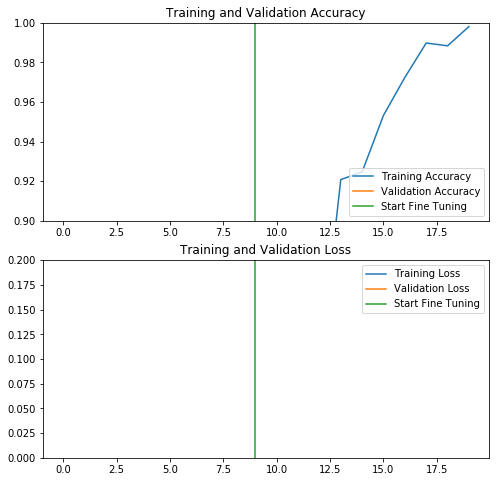

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
classes = [1, 2, 3, 4, 5]

In [23]:
def preprocess(img):
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return keras.applications.mobilenet_v2.preprocess_input(img)

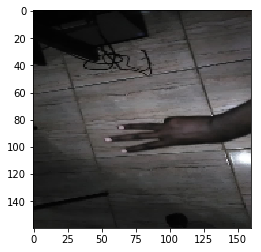

In [27]:
img = keras.preprocessing.image.load_img('test/3/three0010.jpg', target_size=(160,160))
plt.imshow(img)

In [28]:
img = preprocess(img)
pred = model.predict(img)
pred

array([[0.23325896, 0.06644626, 0.6353429 , 0.23310241, 0.14638706]],
      dtype=float32)

In [29]:
classes[int(np.argmax(pred))]

3

In [31]:
# model.save('model.h5')

In [44]:
output_path = tf.contrib.saved_model.save_keras_model(model, 'model_ckpt')
loaded_model = tf.contrib.saved_model.load_keras_model(output_path)


Consider using a TensorFlow optimizer from `tf.train`.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model_ckpt/temp-b'1550171804'/saved_model.pb


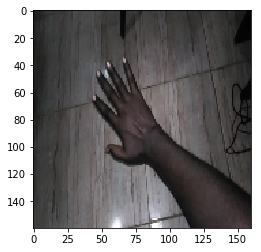

In [47]:
img = keras.preprocessing.image.load_img('test/5/five0001.jpg', target_size=(160,160))
plt.imshow(img)

In [48]:
img = preprocess(img)
pred = loaded_model.predict(img)
print(pred)
print(classes[int(np.argmax(pred))])

[[0.12146272 0.04590661 0.02617991 0.907368   0.94183767]]
5
